# Customer Segmentation Using RFM Analysis 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv(r"D:\data\internship\3\Task 3\online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


## Data Cleaning

In [2]:
df = df.dropna(subset=["CustomerID"])
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Calculate TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

### Creating RFM Table

In [3]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]


### Scoring the RFM

In [4]:
# Score each column: 1 (low) to 5 (high)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RFM Scores
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)


### Segment Customers

In [5]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)


### Visualize RFM Segments

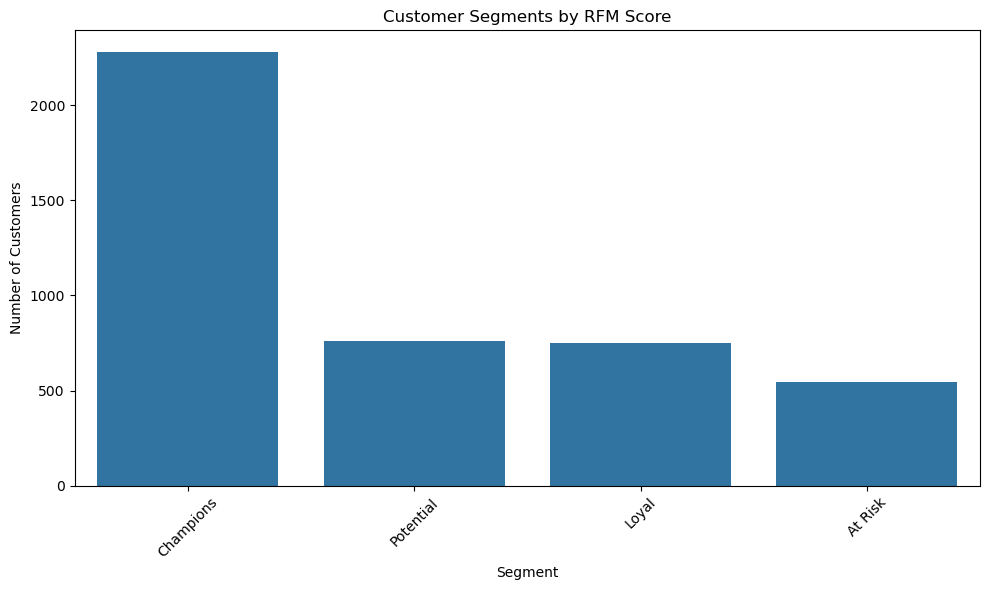

In [6]:
# Bar plot of customer segments
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.title("Customer Segments by RFM Score")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Marketing Ideas

| Segment       | Strategy                           |
| ------------- | ---------------------------------- |
| **Champions** | Exclusive offers, loyalty rewards  |
| **Loyal**     | Personalized recommendations       |
| **Potential** | Targeted promotions or onboarding  |
| **At Risk**   | Win-back emails, special discounts |
